
# NFL Elo Ratings (nflverse + `nfl_data_py`)

This notebook computes NFL Elo ratings using **public schedules/results** from the nflverse (via `nfl_data_py`).  
It includes:
- Home-field advantage (HFA) with neutral-site handling (Super Bowl, explicit "neutral" locations)
- Margin-of-victory (MOV) scaling
- Optional rest-day bumps (already provided in schedules)
- Playoff K multiplier
- Between-season regression toward the league mean
- CSV exports and quick peeks

> Tip: Run the cells top-to-bottom. Adjust parameters in the **Config** cell.


In [1]:
# %%
from __future__ import annotations

import math
from typing import Dict, Tuple, Iterable, List

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

# --- Config (feel free to tune) ----------------------------------------------
YEARS: Iterable[int] = range(2011, 2026)

BASE_RATING       = 1500.0
LEAGUE_MEAN       = 1500.0
SEASON_REGRESSION = 0.40
K_BASE            = 20.0
K_PLAYOFF_MULT    = 1.2
HOME_FIELD_ELO    = 40.0
RDIFF_SCALE       = 400.0
TIE_VALUE         = 0.5
NEUTRAL_IF_SUPER_BOWL = True

# Market blend knobs
MARKET_WEIGHT = 0.35   # how much to trust market vs Elo (0..1)
MARKET_SIGMA  = 13.5   # points SD for spread→win prob mapping (fallback path only)
SPREAD_SIGN   = 1      # inferred later if we need spread ( +1 means positive=home favored )

try:
    import nfl_data_py as nfl
except Exception as e:
    raise SystemExit(
        "Please install:\n  pip install --upgrade nfl_data_py pandas matplotlib\n"
        f"Original import error: {e}"
    )


In [2]:
# %%
def mov_multiplier(mov: float, elo_diff_no_bumps: float) -> float:
    if mov <= 0:
        return 1.0
    return math.log(mov + 1.0) * (2.2 / ((abs(elo_diff_no_bumps) / 1000.0) + 2.2))

def rest_elo_bump(rest_days) -> float:
    if pd.isna(rest_days):
        return 0.0
    try:
        r = float(rest_days)
    except Exception:
        return 0.0
    if r <= 3:
        return -15.0
    if r >= 8:
        return +25.0
    return 0.0

def expected_prob(elo_team: float, elo_opp: float) -> float:
    dr = (elo_team - elo_opp) / RDIFF_SCALE
    return 1.0 / (1.0 + 10.0 ** (-dr))

def regress_to_mean(prev: Dict[str, float], mean: float, frac: float) -> Dict[str, float]:
    return {t: mean * frac + r * (1.0 - frac) for t, r in prev.items()}

def outcome_points(home_pts: int, away_pts: int) -> Tuple[float, float, int]:
    if home_pts > away_pts: return 1.0, 0.0, home_pts - away_pts
    if home_pts < away_pts: return 0.0, 1.0, away_pts - home_pts
    return TIE_VALUE, TIE_VALUE, 0

# %%
from math import erf, sqrt

def prob_from_american_odds(odds) -> float | None:
    """American odds → implied probability (with vig)."""
    if pd.isna(odds): return None
    try: o = float(odds)
    except Exception: return None
    if o < 0:  return (-o) / ((-o) + 100.0)
    else:      return 100.0 / (o + 100.0)

def devig_two_way(p_home_raw: float | None, p_away_raw: float | None):
    """Remove overround (vig) from two-outcome market."""
    if p_home_raw is None or p_away_raw is None: return None, None
    s = p_home_raw + p_away_raw
    if s <= 0: return None, None
    return p_home_raw / s, p_away_raw / s

def market_home_winprob_from_moneylines(home_ml, away_ml) -> float | None:
    """Fair P(home win) from moneylines (preferred path)."""
    ph = prob_from_american_odds(home_ml)
    pa = prob_from_american_odds(away_ml)
    ph_fair, pa_fair = devig_two_way(ph, pa)
    return ph_fair

def _norm_cdf(z: float) -> float:
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def market_home_winprob_from_spread(home_spread: float, sigma_pts: float, sign: int) -> float | None:
    """
    Fallback if moneylines missing: convert spread to win prob.
    sign=+1 means positive spread => home favored; -1 means opposite.
    """
    if pd.isna(home_spread): return None
    try: s = float(home_spread)
    except Exception: return None
    return _norm_cdf((sign * s) / sigma_pts)

def blend_probs(p_elo: float, p_mkt: float | None, w: float) -> float:
    return p_elo if p_mkt is None else (1.0 - w) * p_elo + w * p_mkt

def infer_spread_sign(df: pd.DataFrame) -> int:
    """Infer whether positive spread implies higher home win rate."""
    if "home_spread" not in df.columns: return 1
    sub = df.dropna(subset=["home_spread"]).copy()
    if len(sub) < 200: return 1
    home_win = (sub["home_score"] > sub["away_score"]).astype(int)
    corr = sub["home_spread"].corr(home_win)
    return 1 if corr > 0 else -1

# %%
def load_games(years: Iterable[int]) -> pd.DataFrame:
    raw = nfl.import_schedules(list(years))
    df = raw[raw["home_score"].notna() & raw["away_score"].notna()].copy()

    df["date"]       = pd.to_datetime(df["gameday"])
    df["season"]     = df["season"].astype(int)
    df["week"]       = df["week"].astype(int)
    df["home_team"]  = df["home_team"].astype(str)
    df["away_team"]  = df["away_team"].astype(str)
    df["home_score"] = df["home_score"].astype(int)
    df["away_score"] = df["away_score"].astype(int)
    df["game_type"]  = df["game_type"].astype(str)
    df["is_playoff"] = (df["game_type"] != "REG").astype(int)

    # Moneylines
    for col in ("home_moneyline", "away_moneyline"):
        df[col] = pd.to_numeric(df[col], errors="coerce") if col in df.columns else pd.NA

    # Optional spread (if present)
    if "spread_line" in df.columns:
        df["home_spread"] = pd.to_numeric(df["spread_line"], errors="coerce")
    else:
        df["home_spread"] = pd.NA

    # Rest days
    df.rename(columns={"home_rest": "home_rest_days", "away_rest": "away_rest_days"}, inplace=True)

    # Neutral-site
    loc_is_neutral = df["location"].astype(str).str.contains("neutral", case=False, na=False) if "location" in df.columns else pd.Series(False, index=df.index)
    sb_neutral = df["game_type"].str.upper().eq("SB") if NEUTRAL_IF_SUPER_BOWL else pd.Series(False, index=df.index)
    df["neutral_site"] = (loc_is_neutral | sb_neutral).astype(int)

    df = df.sort_values(["date", "season", "week"]).reset_index(drop=True)
    return df[[
        "date","season","week","game_type","is_playoff",
        "home_team","away_team","home_score","away_score",
        "home_rest_days","away_rest_days","neutral_site",
        "home_moneyline","away_moneyline","home_spread"
    ]]

# %%
def compute_elo(
    games: pd.DataFrame,
    market_weight: float = MARKET_WEIGHT,
    market_sigma: float = MARKET_SIGMA,
    spread_sign: int = SPREAD_SIGN
) -> tuple[pd.DataFrame, pd.DataFrame]:
    ratings: Dict[str, float] = {}
    last_season = None
    out_rows: List[dict] = []

    def get_rating(team: str) -> float:
        if team not in ratings:
            ratings[team] = BASE_RATING
        return ratings[team]

    for _, g in games.iterrows():
        season = int(g["season"])
        week   = int(g["week"])
        date   = pd.to_datetime(g["date"]).date()
        h, a   = str(g["home_team"]), str(g["away_team"])
        hs, as_ = int(g["home_score"]), int(g["away_score"])
        neutral   = bool(g["neutral_site"])
        is_playoff = bool(g["is_playoff"])

        if last_season is None:
            last_season = season
        elif season != last_season:
            ratings.update(regress_to_mean(ratings, LEAGUE_MEAN, SEASON_REGRESSION))
            last_season = season

        home_pre = get_rating(h)
        away_pre = get_rating(a)

        h_rest_bump = rest_elo_bump(g.get("home_rest_days"))
        a_rest_bump = rest_elo_bump(g.get("away_rest_days"))
        hfa = 0.0 if neutral else HOME_FIELD_ELO

        home_adj = home_pre + hfa + h_rest_bump
        away_adj = away_pre + a_rest_bump

        # Expectations
        E_home_elo = expected_prob(home_adj, away_adj)

        # Prefer moneylines; fallback to spread if needed
        E_home_mkt = market_home_winprob_from_moneylines(g.get("home_moneyline"), g.get("away_moneyline"))
        if E_home_mkt is None and not pd.isna(g.get("home_spread", pd.NA)):
            E_home_mkt = market_home_winprob_from_spread(g.get("home_spread"), sigma_pts=market_sigma, sign=spread_sign)

        E_home = blend_probs(E_home_elo, E_home_mkt, w=market_weight)
        E_away = 1.0 - E_home

        # Outcome & K
        S_home, S_away, mov = outcome_points(hs, as_)
        K = K_BASE * (K_PLAYOFF_MULT if is_playoff else 1.0)

        elo_diff_for_mov = (home_pre + (0.0 if neutral else HOME_FIELD_ELO)) - away_pre
        mult = mov_multiplier(mov, elo_diff_for_mov)
        K_adj = K * mult

        # Updates
        home_post = home_pre + K_adj * (S_home - E_home)
        away_post = away_pre + K_adj * (S_away - E_away)

        ratings[h] = home_post
        ratings[a] = away_post

        out_rows.append({
            "date": date.isoformat(),
            "season": season, "week": week,
            "home_team": h, "away_team": a,
            "home_score": hs, "away_score": as_,
            "neutral_site": int(neutral), "is_playoff": int(is_playoff),
            "home_rest_days": g.get("home_rest_days"), "away_rest_days": g.get("away_rest_days"),
            "hfa_applied": round(hfa, 1),
            "home_rating_pre": round(home_pre, 2), "away_rating_pre": round(away_pre, 2),
            "home_rating_pregame": round(home_adj, 2), "away_rating_pregame": round(away_adj, 2),
            "E_home_elo": round(E_home_elo, 4),
            "E_home_mkt": (round(E_home_mkt, 4) if E_home_mkt is not None else None),
            "E_home": round(E_home, 4), "E_away": round(E_away, 4),
            "mov": mov, "K_base": K_BASE, "K_playoff_mult": (K_PLAYOFF_MULT if is_playoff else 1.0),
            "mov_mult": round(mult, 4), "K_adj": round(K_adj, 4),
            "home_rating_post": round(home_post, 2), "away_rating_post": round(away_post, 2),
        })

    game_log = pd.DataFrame(out_rows)

    # Final ratings per team/season
    final = (
        pd.concat([
            game_log[["season", "home_team", "home_rating_post"]].rename(columns={"home_team":"team","home_rating_post":"rating"}),
            game_log[["season", "away_team", "away_rating_post"]].rename(columns={"away_team":"team","away_rating_post":"rating"}),
        ], ignore_index=True)
        .sort_values(["season","team","rating"])
        .groupby(["season","team"], as_index=False).last()
        .rename(columns={"rating":"final_rating"})
        .sort_values(["season","final_rating"], ascending=[True,False])
        .reset_index(drop=True)
    )
    return game_log, final


In [3]:
# %%
schedules = load_games(YEARS)
print(f"Loaded {len(schedules):,} finished games across {schedules['season'].min()}–{schedules['season'].max()}.")

# Only used if we end up falling back to spread
SPREAD_SIGN = infer_spread_sign(schedules)
print("SPREAD_SIGN (for spread fallback):", SPREAD_SIGN)

schedules.head()


Loaded 3,811 finished games across 2011–2024.
SPREAD_SIGN (for spread fallback): 1


,date,season,week,game_type,is_playoff,home_team,away_team,home_score,away_score,home_rest_days,away_rest_days,neutral_site,home_moneyline,away_moneyline,home_spread
0,2011-09-08,2011,1,REG,0,GB,NO,42,34,7,7,0,-250.0,222.0,4.5
1,2011-09-11,2011,1,REG,0,BAL,PIT,35,7,7,7,0,-125.0,113.0,1.0
2,2011-09-11,2011,1,REG,0,CHI,ATL,30,12,7,7,0,105.0,-116.0,-1.0
3,2011-09-11,2011,1,REG,0,CLE,CIN,17,27,7,7,0,-310.0,273.0,6.5
4,2011-09-11,2011,1,REG,0,HOU,IND,34,7,7,7,0,-430.0,369.0,9.0


In [4]:

# %%
game_log, final = compute_elo(schedules, market_weight=MARKET_WEIGHT, market_sigma=MARKET_SIGMA, spread_sign=SPREAD_SIGN)
print(f"Computed Elo updates for {len(game_log):,} games.")

game_log.to_csv("elo_game_log.csv", index=False)
last_season_done = int(game_log["season"].max())
final_last = final.query("season == @last_season_done").copy()
final_last.to_csv(f"elo_final_ratings_{last_season_done}.csv", index=False)

print("Saved: elo_game_log.csv")
print(f"Saved: elo_final_ratings_{last_season_done}.csv")

game_log.tail(3)


Computed Elo updates for 3,811 games.
Saved: elo_game_log.csv
Saved: elo_final_ratings_2024.csv


,date,season,week,home_team,away_team,home_score,away_score,neutral_site,is_playoff,home_rest_days,away_rest_days,hfa_applied,home_rating_pre,away_rating_pre,home_rating_pregame,away_rating_pregame,E_home_elo,E_home_mkt,E_home,E_away,mov,K_base,K_playoff_mult,mov_mult,K_adj,home_rating_post,away_rating_post
3808,2025-01-26,2024,21,PHI,WAS,55,23,0,1,7,8,40.0,1727.13,1603.63,1767.13,1628.63,0.6894,0.6854,0.6880,0.3120,32,20.0,1.2,3.2546,78.1111,1751.51,1579.26
3809,2025-01-26,2024,21,KC,BUF,32,29,0,1,8,7,40.0,1733.08,1729.75,1798.08,1729.75,0.5971,0.5174,0.5692,0.4308,3,20.0,1.2,1.3595,32.6284,1747.14,1715.69
3810,2025-02-09,2024,22,PHI,KC,40,22,1,1,14,14,0.0,1751.51,1747.14,1776.51,1772.14,0.5063,0.4783,0.4965,0.5035,18,20.0,1.2,2.9386,70.5266,1787.02,1711.63


In [5]:
final_last.head(32)

,season,team,final_rating
416,2024,PHI,1787.02
417,2024,KC,1760.33
418,2024,DET,1735.56
419,2024,BUF,1729.75
420,2024,BAL,1709.50
421,2024,GB,1657.60
422,2024,MIN,1657.00
423,2024,SF,1628.80
424,2024,PIT,1627.25
425,2024,WAS,1603.63


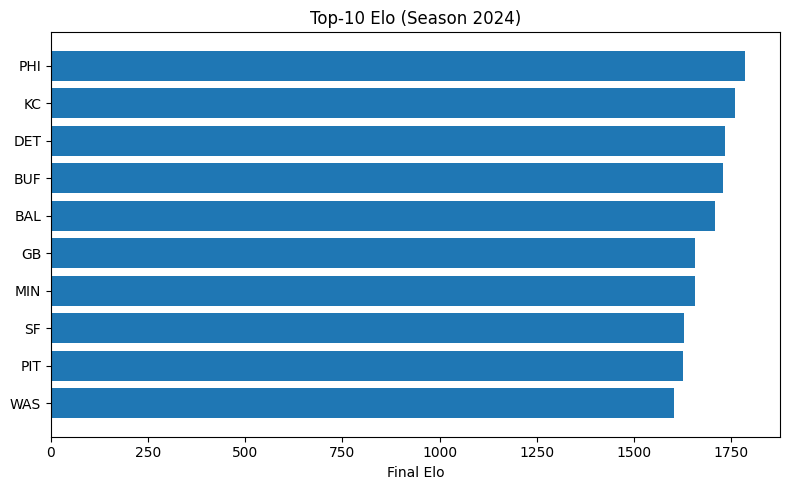

In [6]:
# %%
top = final_last.head(10).sort_values("final_rating", ascending=True)
plt.figure(figsize=(8,5))
plt.barh(top["team"], top["final_rating"])
plt.xlabel("Final Elo")
plt.title(f"Top-10 Elo (Season {last_season_done})")
plt.tight_layout()
plt.show()





## Parameter choices & rationale

- **YEARS**: `range(1999, 2026)` — nflverse has modern, consistent coverage back to 1999; future games are automatically ignored because they lack final scores.
- **BASE_RATING / LEAGUE_MEAN = 1500** — 1500 is the standard Elo midpoint. Using the same value for the mean makes between-season regression easy and interpretable.
- **SEASON_REGRESSION = 0.33** — Regressing ~1/3 of the way to league average before Week 1 maintains continuity while letting ratings drift back over time; empirically this avoids stale priors dominating early seasons.
- **K_BASE = 20.0** — Controls learning rate per game. Values in the ~16–24 range typically balance responsiveness with stability for NFL samples. We also scale by MOV so blowouts move ratings more.
- **K_PLAYOFF_MULT = 1.2** — Slightly larger stakes in playoffs; amplifies information in those games without overpowering season-long data.
- **HOME_FIELD_ELO = 55** — Roughly corresponds to ~2 to 2.5 points of scoreboard advantage, which is in line with modern NFL home-field edge after accounting for a gradual decline from older ~3-point norms.
- **RDIFF_SCALE = 400** — This is the traditional Elo logistic scale. With 400 Elo points implying a 10× odds ratio, it keeps probabilities in a familiar range.
- **TIE_VALUE = 0.5** — Standard Elo convention for draws.

> If you want to **tune** these from data, add the optional calibration cell below to search over K/HFA/regression and minimize log loss or Brier score on a holdout period.


In [7]:
# # %%  Grid tuning (rolling, walk-forward across seasons)
# import itertools, time, numpy as np, pandas as pd

# # --- tiny helpers -------------------------------------------------------------
# def logloss_from_rows(df: pd.DataFrame, use_col: str) -> float:
#     y = np.where(df["home_score"] > df["away_score"], 1.0,
#         np.where(df["home_score"] < df["away_score"], 0.0, 0.5))
#     p = df[use_col].astype(float).clip(1e-6, 1-1e-6).to_numpy()
#     loss = np.where(y==0.5, -0.5*(np.log(p)+np.log(1-p)),
#                     -(y*np.log(p)+(1-y)*np.log(1-p)))
#     return float(loss.mean())

# _SCHED_CACHE: dict[tuple[int,int], tuple[pd.DataFrame,int]] = {}

# def evaluate_params_rolling(
#     train_start=2011,
#     val_seasons=range(2019, 2025),
#     k_base=20.0,
#     hfa=45.0,
#     reg=0.40,
#     k_playoff_mult=1.2,
#     market_weight=0.35,
#     market_sigma=13.5,
# ):
#     """Average logloss across val_seasons; for each N, we run years [train_start..N] and score only season N."""
#     global K_BASE, HOME_FIELD_ELO, SEASON_REGRESSION, K_PLAYOFF_MULT
#     K0, H0, R0, KP0 = K_BASE, HOME_FIELD_ELO, SEASON_REGRESSION, K_PLAYOFF_MULT
#     try:
#         K_BASE, HOME_FIELD_ELO, SEASON_REGRESSION, K_PLAYOFF_MULT = k_base, hfa, reg, k_playoff_mult

#         blend_losses, elo_losses, coverages, counted = [], [], [], 0
#         for N in val_seasons:
#             yrs = range(train_start, N+1)
#             key = (yrs.start, yrs.stop-1)
#             if key not in _SCHED_CACHE:
#                 sched = load_games(yrs)
#                 sign  = infer_spread_sign(sched)
#                 _SCHED_CACHE[key] = (sched, sign)
#             else:
#                 sched, sign = _SCHED_CACHE[key]

#             glog, _ = compute_elo(
#                 sched,
#                 market_weight=market_weight,
#                 market_sigma=market_sigma,
#                 spread_sign=sign
#             )
#             sl = glog[glog["season"] == N]
#             if len(sl) == 0:
#                 continue

#             blend_losses.append(logloss_from_rows(sl, "E_home"))
#             elo_losses.append(logloss_from_rows(sl, "E_home_elo"))
#             coverages.append(sl["E_home_mkt"].notna().mean())
#             counted += 1

#         if counted == 0:
#             return np.nan, np.nan, 0.0, 0

#         return float(np.mean(blend_losses)), float(np.mean(elo_losses)), float(np.mean(coverages)), counted
#     finally:
#         K_BASE, HOME_FIELD_ELO, SEASON_REGRESSION, K_PLAYOFF_MULT = K0, H0, R0, KP0

# # --- grid definition (coarse but sensible; expand if you want) ----------------
# param_grid = {
#     "k_base":         [18.0, 20.0, 22.0],
#     "hfa":            [35.0, 40.0, 45.0, 50.0],
#     "reg":            [0.28, 0.33, 0.40],
#     "k_playoff_mult": [1.1, 1.2],
#     "market_weight":  [0.20, 0.30, 0.40],
#     "market_sigma":   [12.5, 13.5, 14.5],   # only used when we fall back to spreads
# }

# # --- run the grid -------------------------------------------------------------
# val_seasons = range(2019, 2025)   # <- change window here
# train_start = 2011                # <- earliest season included for context
# combos = list(itertools.product(*param_grid.values()))

# print(f"Evaluating {len(combos)} combos over seasons {min(val_seasons)}–{max(val_seasons)} (walk-forward)...")
# t0 = time.time()
# rows = []
# for i, (k_base, hfa, reg, kpm, w, sig) in enumerate(combos, 1):
#     blend_ll, elo_ll, cov, nseasons = evaluate_params_rolling(
#         train_start=train_start, val_seasons=val_seasons,
#         k_base=k_base, hfa=hfa, reg=reg, k_playoff_mult=kpm,
#         market_weight=w, market_sigma=sig,
#     )
#     rows.append({
#         "blend_logloss": blend_ll,
#         "eloonly_logloss": elo_ll,
#         "delta_vs_elo": blend_ll - elo_ll,   # negative is better than Elo-only
#         "coverage_mkt": cov,
#         "n_seasons": nseasons,
#         "k_base": k_base, "hfa": hfa, "reg": reg,
#         "k_playoff_mult": kpm, "market_weight": w, "market_sigma": sig
#     })
#     if i % 10 == 0 or i == len(combos):
#         print(f"{i:>4}/{len(combos)} done...")

# res = pd.DataFrame(rows).sort_values(["blend_logloss", "delta_vs_elo"]).reset_index(drop=True)
# t1 = time.time()

# print(f"\nCompleted in {t1 - t0:.1f}s. Top 10:")
# display(res.head(10))

# best = res.iloc[0].to_dict()
# print("\nBest params:")
# for k in ["k_base","hfa","reg","k_playoff_mult","market_weight","market_sigma"]:
#     print(f"  {k}: {best[k]}")
# print(f"\nBest blend logloss: {best['blend_logloss']:.6f} (Elo-only: {best['eloonly_logloss']:.6f}, Δ={best['delta_vs_elo']:.6f})")
# print(f"Market coverage across seasons: {best['coverage_mkt']:.3f} over {int(best['n_seasons'])} seasons")
